In [10]:
%load_ext autoreload
%autoreload 2

import os
import json
import wandb
import argparse

import torch
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode


from pytorch_metric_learning import distances, losses, miners, reducers, testers
from dataset import StreetHazardDataset, PadToMultipleOf16, StreetHazardDatasetTriplet

from model_new import DinoMetricLearning, DinoUpsampling, DinoSegmentation
from train import train_metric_learning
from loss import FixedWeighting, NormalizedWeighting, UncertaintyWeighting

import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

COLAB = False
KAGGLE = False
NUM_CLASSES = 13
SEED = 42
ORIGINAL_IMAGE_SIZE = (720, 1280)

# Seed everything
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

sns.set_theme(style="whitegrid", context="paper", font_scale=1.8)
plt.rcParams['font.family'] = ['cmr10']
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
SCALE_FACTOR = 1
PREPROCESS = "resize"
BATCH_SIZE = 1
NUM_WORKERS = 2
DINO_REPO = "./dinov3"
CNN_OUT_DIM = 16
EMBEDDING_DIM = 256

In [12]:
image_size = PadToMultipleOf16().convert_dims(
    (ORIGINAL_IMAGE_SIZE[0] * SCALE_FACTOR, ORIGINAL_IMAGE_SIZE[1] * SCALE_FACTOR)
)

if KAGGLE:
    annotations_train_file = "/kaggle/input/streethazards-train/train/train.odgt"
    annotation_val_file = "/kaggle/input/streethazards-train/train/validation.odgt"
    annotation_test_file = "/kaggle/input/streethazards-test/test/test.odgt"
    img_dir = "/kaggle/input/streethazards-train/train/"
    img_dir_test = "/kaggle/input/streethazards-test/test/"
else:
    annotations_train_file = "./data/train/train.odgt"
    annotation_val_file = "./data/train/validation.odgt"
    annotation_test_file = "./data/test/test.odgt"
    img_dir = "./data/train/"
    img_dir_test = "./data/test/"

if PREPROCESS == "resize":
    image_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize(image_size, interpolation=InterpolationMode.BICUBIC),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ]
    )

    target_transform = transforms.Compose(
        [
            transforms.Resize(image_size, interpolation=InterpolationMode.NEAREST),
        ]
    )
elif PREPROCESS == "crop":
    image_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.RandomCrop(image_size),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ]
    )

    target_transform = transforms.Compose(
        [
            transforms.RandomCrop(image_size),
        ]
    )

dataset_train = StreetHazardDataset(
    annotations_train_file,
    img_dir,
    image_transform=image_transform,
    target_transform=target_transform,
    positive_pairs=False,
)

dataset_val = StreetHazardDataset(
    annotation_val_file,
    img_dir,
    image_transform=image_transform,
    target_transform=target_transform,
    positive_pairs=False,
)

dataset_test = StreetHazardDataset(
    annotation_test_file,
    img_dir_test,
    image_transform=image_transform,
    target_transform=target_transform,
    positive_pairs=False,
)

dl_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)
dl_train = DataLoader(
    dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() and NUM_WORKERS > 0 else False,
)

# Data Exploration

The dataset used for this assignment is the [Street Hazards](https://arxiv.org/abs/1911.11132) dataset, which is a synthetic dataset designed for anomaly detection in street scenes. The dataset contains images of street scenes with various types of anomalies, such as unusual objects or unexpected events.

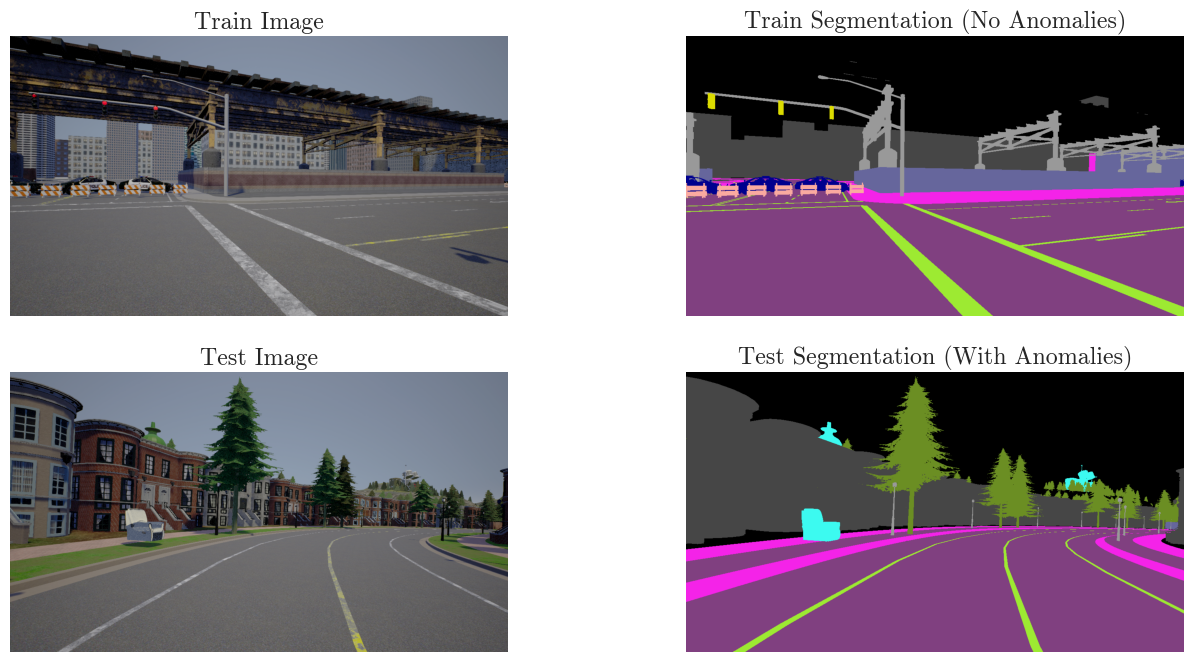

In [13]:
from plot import color, de_normalize
import matplotlib.pyplot as plt

INDEX = 2
train_image, train_segmentation = dataset_train[INDEX]
test_image, test_segmentation = dataset_test[INDEX]

plt.figure(figsize=(16,8))
plt.subplot(2,2, 1)
plt.title("Train Image")
plt.imshow(de_normalize(train_image).permute(1, 2, 0))
plt.axis('off')
plt.subplot(2,2, 2)
plt.title("Train Segmentation (No Anomalies)")
plt.imshow(color(train_segmentation))
plt.axis('off')
plt.subplot(2,2, 3)
plt.title("Test Image")
plt.imshow(de_normalize(test_image).permute(1, 2, 0))
plt.axis('off')
plt.subplot(2,2, 4)
plt.title("Test Segmentation (With Anomalies)")
plt.imshow(color(test_segmentation))
plt.axis('off')
plt.show()

# Open-World Semantic Segmentation Approach

The task of this assignment is to perform open-world semantic segmentation, which involves segmenting images into known classes while also identifying and segmenting unknown or anomalous objects (as a new unseen class).
The particular challenge of this task is that the model does not have access to any examples of the unknown classes during training, and must rely on its ability to generalize from the known classes to identify and segment the unknown classes.
The proposed approach is the following:
- Use a foundation model (DINOv3) to extract features from the images.
- Train a segmentation head using two losses:
  - Cross-entropy loss for the known classes.
  - A metric learning loss (e.g., contrastive loss) to encourage the model to learn a feature space where known classes are well-separated.
- During inference, use the logits from the segmentation head to identify unknown classes by thresholding the maximum softmax probability.

# Model

![Alt text](./ML4CV%20Diagram.drawio.svg)

The model consists of the following components:
1. **Frozen backbone**: A pre-trained [DINOv3](https://github.com/facebookresearch/dinov3) model is used as a feature extractor. The model is frozen during training to leverage the rich feature representations learned from large-scale data.
2. **Small CNN**: A small CNN takes the input image and extracts low level, but high-resolution features. These features are then summed with the features from the DINOv3 backbone to provide both high-level and low-level information to the segmentation head.
3. **Segmentation head**: A simple $1 \times 1$ convolutional layer is used as the segmentation head. This layer takes the combined features from the backbone and the small CNN and produces logits for each class (excluding the unknown class).
4. **Anomaly Detector**: Use [energy based](https://arxiv.org/abs/2010.03759) method to identify anomalies. The energy score is computed from the logits produced by the segmentation head.

In [37]:
backbone = torch.hub.load(
    DINO_REPO,
    "dinov3_vits16",
    source="local",
    weights="https://dinov3.llamameta.net/dinov3_vits16/dinov3_vits16_pretrain_lvd1689m-08c60483.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiOHppYnI1MjB4NzVzNGZxbXpodTVnbndzIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTY5MTUxNDF9fX1dfQ__&Signature=Xw7TaFMGn3Z7y9Y12-R1virV1ZQPfblWOGr-7wBgcxwMkNj3NvuXC18tN%7ERAbvKKGNQgvXPBQoVc1XfAvphfUOXQi7tqCt2RbLojJlelfnwDnN0QoqhnMLWUgAXHhDc0VyqQcrXYAy44mx8dqyIVGLH37ca0196hdIoXutZEtnrtnLHqhr9-QR2qsOkwV0yl0oUGoATHwvDb8W1ChnkVoS0t08LogKZd1likEx25ZIW5g2FM2IMfpyyiV8Z5-DOQythF4eeocyqMJHFpqhI7pBgUDRyji3daJQzB6PefNvEda7G6g30rVzEj5FTFdXAOR4favjoGKa%7Eh1x5OePLhlw__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=1292726919301558",
).to(device)
feature_extractor = DinoMetricLearning(
    backbone,
    dino_out_dim=None,
    cnn_out_dim=CNN_OUT_DIM,
    out_dim=EMBEDDING_DIM,
).to(device)
model = DinoSegmentation(
    feature_extractor,
    num_classes=NUM_CLASSES,
).to(device)

An alternative model without the small CNN (denoted `model_upsampling`) is also implemented to evaluate the impact of low-level features on the performance.

In [39]:
model_upsampling = DinoSegmentation(
    DinoUpsampling(
        backbone, out_dim=EMBEDDING_DIM
    ),
    num_classes=NUM_CLASSES,
).to(device)

# Training

To train the model, the following loss is used:

$$ \mathcal{L} = \lambda_{1} \cdot \mathcal{L}_{CE} + \lambda_{2} \cdot \mathcal{L}_{\texttt{metric}}$$

where:
- $\mathcal{L}_{CE}$ is the cross-entropy loss for the known classes. This loss encourages the model to correctly classify pixels belonging to known classes. Used to perform the classical semantic segmentation task.
- $\mathcal{L}_{\texttt{metric}}$ is a metric learning loss (e.g., contrastive loss) that encourages the model to learn a feature space where known classes are well-separated. The following choice for $\mathcal{L}_{\texttt{metric}}$ are tested:
  - [**Proxy-Anchor Loss**](https://arxiv.org/abs/2003.13911): This loss introduces a set of learnable **proxies** (one per class) that serve as anchors. Each proxy attracts embeddings of its own class while repelling embeddings of other classes. Unlike Proxy-NCA, Proxy-Anchor aggregates **all positives and negatives** per proxy with a log-sum-exp, which emphasizes harder samples and stabilizes optimization.
  - **Triplet Margin Loss**: Mines many triplets (anchor, positive, negative) within a batch and tries to ensure that the distance between the anchor and positive is smaller than the distance between the anchor and negative by a margin.
  - [**NT-Xent Loss**](arxiv.org/abs/1807.03748): A contrastive loss that encourages similar samples to be close in the feature space while pushing dissimilar samples apart. It uses a temperature parameter to scale the logits before applying the softmax function.
- $\lambda_1, \lambda_2$ are hyperparameters that control the relative importance of the two loss components.

All the training history can be inspected at the following Weights & Biases project: [ML4CV_Assignment](https://wandb.ai/luca24ever_unibo/ML4CV_Assignment).

# Anomaly Detection

To detect anomalies using the trained model, the following approaches has been tested:
- **Maximum Softmax Probability (MSP)**: This method uses the maximum softmax probability from the segmentation head as a confidence score. The lower the confidence, the more likely the pixel is to be an anomaly. Note that this approach works in the space of the logits, so after the segmentation head.
- **Guassian Mixture Model (GMM)**: This method fits a GMM to the feature embeddings of the known classes. During inference, the likelihood of each pixel's embedding under the GMM is computed, and pixels with low likelihoods are considered anomalies. This approach works in the feature space, so before the segmentation head.

# Model Evaluation

Tried different losses for the metric learning component:
- Proxy-NCA loss
- NT-Xent loss
- Triplet loss
- No metric learning loss (only cross-entropy loss)

Tried 2 different models:
- Model with small CNN (denoted `model`)
- Model without small CNN (denoted `model_upsampling`)

In [ ]:
model.load_state_dict(torch.load("./weights/proxy_metric_fixed.pth", map_location=device))

<All keys matched successfully>

# Structure
## Data exploration
## Approaches
## Model evaluation
## Ablation study
## Conclusion

# Discarded approaches

## Loss weighting
Since the two losses, $\mathcal{L}_{CE}$ and $\mathcal{L}_{\texttt{metric}}$, have different scales, I tried to weight them using [Uncertainty Weighting](https://arxiv.org/abs/1705.07115) and [Normalized Weighting](https://arxiv.org/abs/1711.02257v4). However, both methods did not improve the performance of the model, and the best performing method was using the two hyperparams $\lambda_1$ and $\lambda_2$.

## Autoencoder

I also tested an autoencoder approach, where the model is trained to reconstruct the input image. The idea is that the model will learn to reconstruct known classes well, but will struggle to reconstruct unknown classes, leading to higher reconstruction errors for anomalies. However, the resulting model were not able to achieve good reconstruction quality, hence reducing the effectiveness of this approach.